In [104]:
### Python imports ###
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt


In [105]:
### Local imports ###
import sys
sys.path.append('../') # define relative path for local imports
from src.models.scm import NAFNet_Combine


In [106]:
# Load image from /var/hub/VITON-HD/train/image/03308_00.jpg
from PIL import Image
from refiners.fluxion.utils import image_to_tensor
def load_image(image_path: str) -> Image.Image:
        try:
            image = Image.open(image_path).convert("RGB")
            image = image_to_tensor(image).squeeze(0)
            return image
        except Exception as e:
            print(f"Error loading image '{file}': {e}")
            return None

path_gt = '/var/hub/VITON-HD/test/image/00006_00.jpg'
path_result = '/var/hub/VITON-HD-results-ladi-vton/paired/upper_body/00006_00.jpg'
image_gt = load_image(path_gt)
image_result = load_image(path_result)

transform = transforms.Compose([
    transforms.Resize((512, 384))  # Resize to 512x384
])

resized_gt = transform(image_gt)

print(resized_gt.shape,  image_result.shape)
concat_image = torch.cat((resized_gt, image_result),0)
        
# path = '/var/hub/VITON-HD/test/image/00006_00.jpg'
# image = load_image(path)
# concat_image = torch.cat((image, image),0)


torch.Size([3, 512, 384]) torch.Size([3, 512, 384])


In [107]:
batch = torch.unsqueeze(concat_image, 0)

In [108]:
img_channel = 6
width = 32

enc_blks = [2, 2, 4, 8]
middle_blk_num = 12
dec_blks = [2, 2, 2, 2]

net = NAFNet_Combine(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
                    enc_blk_nums=enc_blks, dec_blk_nums=dec_blks)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 384])
torch.Size([3, 512, 384])
torch.Size([512, 384, 3])


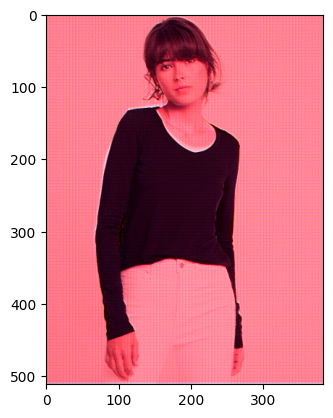

In [109]:
with torch.no_grad():
    out = net(batch)
    print(out.shape)

out = out.squeeze(0) # remove batch dimension
print(out.shape)
out = out.permute(1, 2, 0) # rearrange dimensions from (height, width, channels) to (channels, height, width)
print(out.shape)
# out = TF.to_pil_image(out) # convert to PIL image
# print(out)

# out.show()
plt.imshow(out)
# out.show()
    